# Plot Scores and Ablations

The Objective of this notebook is to better understand the relative importance of edges for performance on tasks, 
and see if we can construct a heuristic method for selecting a score threshold that captures a "knee" in the peformance recovered graph

Some experiments to run: 
- Generate aggegrate gra

In [1]:
from functools import partial
import torch

from cupbearer.tasks.tiny_natural_mechanisms import get_effect_tokens

from elk_experiments.utils import repo_path_to_abs_path, set_model, repo_path_to_abs_path
from elk_experiments.auto_circuit_utils import make_prompt_data_loader, make_mixed_prompt_dataloader, sorted_scores

from auto_circuit.types import AblationType
from auto_circuit.data import PromptPairBatch   
from auto_circuit.prune_algos.mask_gradient import mask_gradient_prune_scores

In [2]:
model_name = "pythia-70m"
device="cpu"
task_name="ifelse"
resid_pre=False 
resid_post=False 
attn=True 
mlp=False

In [3]:
from cupbearer import tasks
from elk_experiments.tiny_natural_mechanisms_utils import get_task_subset
task = get_task_subset(tasks.tiny_natural_mechanisms(task_name, device, model_name), 2048, 1024, 1024)
set_model(task.model, disbale_grad=True)
out_dir = repo_path_to_abs_path(f"output/{task_name}_{model_name}_resid_pre_{resid_pre}_resid_post_{resid_post}_attn_{attn}_mlp_{mlp}")
if not out_dir.exists():
    out_dir.mkdir(parents=True)

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  cpu


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded pretrained model pythia-70m into HookedTransformer
Moving model to device:  cpu


## Aggregate Graph

In [4]:
from auto_circuit.utils.graph_utils import patchable_model
model = patchable_model(
    task.model,
    factorized=True,
    slice_output="last_seq",
    separate_qkv=True,
    device=device,
    resid_src=resid_pre,
    resid_dest=resid_post,
    attn_src=attn,
    attn_dest=attn,
    mlp_src=mlp, 
    mlp_dest=mlp
)

In [5]:
batch_size = 32
effect_tokens = get_effect_tokens(task_name, task.model)
trainloader = make_prompt_data_loader(task.trusted_data, effect_tokens, task.model, batch_size)
testloader = make_prompt_data_loader(task.test_data.normal_data, effect_tokens, task.model, batch_size)

In [7]:
scores_path = out_dir / "scores.pt"
if scores_path.exists():
    attribution_scores = torch.load(scores_path)
else:
    attribution_scores = mask_gradient_prune_scores(
        model=model,
        dataloader=trainloader,
        official_edges=None,
        grad_function="logit",
        answer_function="avg_val",
        mask_val=0.0,
    )
    torch.save(attribution_scores, scores_path)

In [8]:
sorted_scores(attribution_scores, model)[:10]

[('A0.1', 'A1.6.V', tensor(-95.0490)),
 ('A0.1', 'A1.4.V', tensor(-77.5212)),
 ('A0.1', 'A1.0.V', tensor(72.2837)),
 ('A0.1', 'A2.5.V', tensor(-61.6729)),
 ('A0.1', 'A1.7.V', tensor(-53.0332)),
 ('A0.0', 'A1.7.V', tensor(47.8535)),
 ('A0.0', 'A1.3.V', tensor(-45.8856)),
 ('A0.1', 'A2.0.V', tensor(-42.8352)),
 ('A0.0', 'A1.6.V', tensor(41.8781)),
 ('A1.4', 'A2.5.V', tensor(-35.0239))]

## Find Knee in Attribution Scores

In [9]:
import numpy as np
attribution_scores_flat = torch.cat([x.flatten() for x in attribution_scores.values()])
attribution_scores_sorted = np.sort(np.abs(attribution_scores_flat.cpu().numpy()))

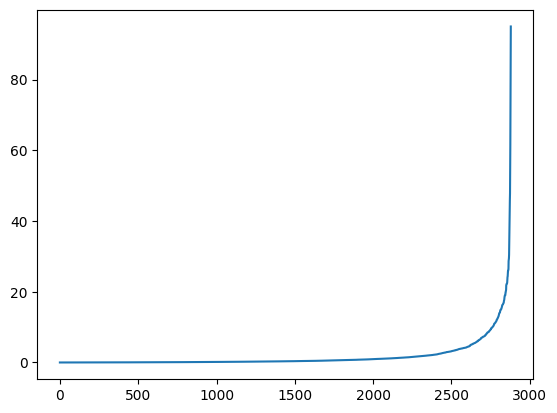

In [10]:
# plot sorted attribution scores
import matplotlib.pyplot as plt
plt.plot(attribution_scores_sorted)

In [11]:
#TODO: try knee Kneedle algorithm to find the knee point
from kneed import DataGenerator, KneeLocator
kneedle = KneeLocator(
    np.arange(len(attribution_scores_flat)), 
    np.sort(np.abs(attribution_scores_flat.cpu().numpy())), 
    S=1.0, 
    curve="convex", 
    direction="increasing",
    interp_method="polynomial"
)

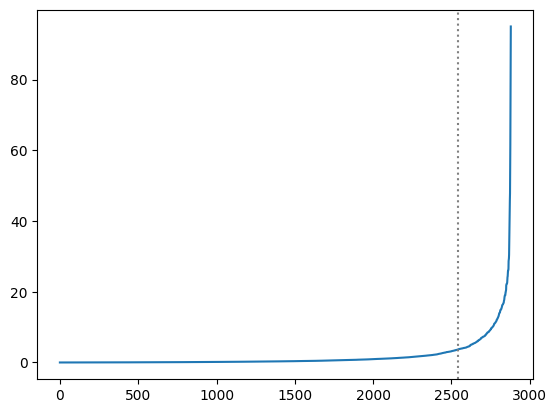

In [13]:
# plot sorted attribution scores
plt.plot(attribution_scores_sorted)
plt.axvline(x=kneedle.knee, color='grey', linestyle=':', label='knee')

## Evaluate Circuit Performance at Different Thresholds

In [14]:
from auto_circuit.prune import run_circuits
from auto_circuit.types import (
    AblationType,
    CircuitOutputs,
    PatchType,
    PruneScores,
    EdgeCounts
)
from auto_circuit.utils.graph_utils import edge_counts_util

In [31]:
from typing import Dict, List, Tuple
import math

import torch as t
from torch.nn.functional import log_softmax

from auto_circuit.data import PromptDataLoader
from auto_circuit.types import BatchKey, CircuitOutputs, Measurements
from auto_circuit.utils.custom_tqdm import tqdm
from auto_circuit.utils.patchable_model import PatchableModel
from auto_circuit.utils.tensor_ops import multibatch_kl_div

def log_answer_dist(logits, answers: torch.Tensor):
    probs = logits.softmax(dim=-1)
    answer_prob = torch.gather(probs, 1, answers).sum(dim=-1)
    answer_dist = torch.stack([answer_prob, 1 - answer_prob], dim=1)
    answer_log_dist = answer_dist.log()
    return answer_log_dist

def measure_kl_div(
    model: PatchableModel,
    dataloader: PromptDataLoader,
    circuit_outs: CircuitOutputs,
    compare_to_clean: bool = True,
    over_vals: bool = False, 
) -> List[Tuple[int, float, torch.Tensor]]:
    """
    Average KL divergence between the full model and the circuits.

    Args:
        model: The model on which `circuit_outs` was calculated.
        dataloader: The dataloader on which the `circuit_outs` was calculated.
        circuit_outs: The outputs of the ablated model for each circuit size.
        compare_to_clean: Whether to compare the circuit output to the full model on the
            clean (`True`) or corrupt (`False`) prompt.
        over_vals: Whether to take KL over [answer, wrong_answer] or entire token distribution

    Returns:
        A list of tuples, where the first element is the number of edges pruned and the
            second element is the average KL divergence for that number of edges.
    """
    circuit_kl_divs: Measurements = []
    default_logprobs: Dict[BatchKey, t.Tensor] = {}
    with t.inference_mode():
        for batch in dataloader:
            default_batch = batch.clean if compare_to_clean else batch.corrupt
            logits = model(default_batch)[model.out_slice]
            default_logprobs[batch.key] = log_softmax(logits, dim=-1) if not over_vals else log_answer_dist(logits, batch.answers)

    for edge_count, circuit_out in (pruned_out_pbar := tqdm(circuit_outs.items())):
        pruned_out_pbar.set_description_str(f"KL Div for {edge_count} edges")
        circuit_logprob_list: List[t.Tensor] = []
        default_logprob_list: List[t.Tensor] = []
        for batch in dataloader:
            circuit_logprob_list.append(log_softmax(circuit_out[batch.key], dim=-1) if not over_vals else log_answer_dist(circuit_out[batch.key], batch.answers))
            default_logprob_list.append(default_logprobs[batch.key])
        
        input_logprobs = t.cat(circuit_logprob_list)
        target_logprobs = t.cat(default_logprob_list)
        n_batch = math.prod(input_logprobs.shape[:-1])
        kl_instance = torch.nn.functional.kl_div( 
            input_logprobs,
            target_logprobs,
            reduction="none",
            log_target=True,
        )
        kl_instance = kl_instance.sum(dim=-1) # sum over "clases"
        kl = kl_instance.sum() / n_batch
        # kl = multibatch_kl_div(input_logprobs, target_logprobs)
       

        # Numerical errors can cause tiny negative values in KL divergence
        circuit_kl_divs.append((edge_count, max(kl.item(), 0), torch.clip(kl_instance, 0, None).tolist()))
    return circuit_kl_divs


In [41]:
def plot_attribution_and_kl_div(
        attribution_scores, 
        kl_divs: List[Tuple[int, float, List[float]]],
        knee, 
        title, 
        plot_interval=False,
        kl_divs_anom=None,
):
    # plot attribution scores and kl_divs
    fig, ax1 = plt.subplots()

    lines = []
    # plot attribution scores
    color = 'tab:red'
    ax1.set_xlabel('edge')
    ax1.set_ylabel('attribution score', color=color)
    attrib_line = ax1.plot(attribution_scores, color=color)
    lines.append((attrib_line[0], 'attrib'))
    ax1.tick_params(axis='y', labelcolor=color)

    # plot kl_divs
    xvals, y_vals, individual_kl_divs = zip(*kl_divs)
    percentile_95 = [np.percentile(kl, 95) for kl in individual_kl_divs]
    percentile_5 = [np.percentile(kl, 5) for kl in individual_kl_divs]
    xvals = [model.n_edges - x for x in xvals]
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('kl_div', color=color)
    
    kl_line = ax2.plot(xvals, y_vals, color=color)
    if plot_interval:
        ax2.fill_between(xvals, percentile_5, percentile_95, color=color, alpha=0.2)
    lines.append((kl_line[0], 'kl_div'))
    ax2.tick_params(axis='y', labelcolor=color)

    # plot anomalous kl_divs if present 
    if kl_divs_anom:
        xvals, y_vals, individual_kl_divs = zip(*kl_divs_anom)
        percentile_95 = [np.percentile(kl, 95) for kl in individual_kl_divs]
        percentile_5 = [np.percentile(kl, 5) for kl in individual_kl_divs]
        xvals = [model.n_edges - x for x in xvals]
        color = 'tab:green'
        kl_anom_line = ax2.plot(xvals, y_vals, color=color)
        if plot_interval:
            ax2.fill_between(xvals, percentile_5, percentile_95, color=color, alpha=0.2)
        lines.append((kl_anom_line[0], 'kl_div_anom'))

    # plot knee 
    knee_line = ax1.axvline(x=knee, color='grey', linestyle=':', label='knee')
    lines.append((knee_line, 'knee'))

    # legend
    lines, labels = zip(*lines)
    fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.15, 0.85))

    # title 
    plt.title(f"Attribution scores and KLDivs {title}")


### KL on Full Distribution

In [19]:
# circuit_outs_path = out_dir / "circuit_outs.pt"
# if circuit_outs_path.exists():
#     circuit_outs = torch.load(circuit_outs_path)
# else:
circuit_outs: CircuitOutputs = run_circuits(
    model=model,
    dataloader=testloader,
    test_edge_counts=
    #[0, model.n_edges - kneedle.knee, model.n_edges],
    edge_counts_util(
        edges=model.edges, 
        prune_scores=attribution_scores,
        test_counts=EdgeCounts.LOGARITHMIC
    ),
    prune_scores=attribution_scores,
    patch_type=PatchType.TREE_PATCH,
    ablation_type=AblationType.ZERO,
)
    # torch.save(circuit_outs, circuit_outs_path)

In [32]:
kl_divs = measure_kl_div(model, testloader, circuit_outs, over_vals=True)

In [37]:
assert np.allclose(kl_divs[0][1], np.mean(kl_divs[0][2]))

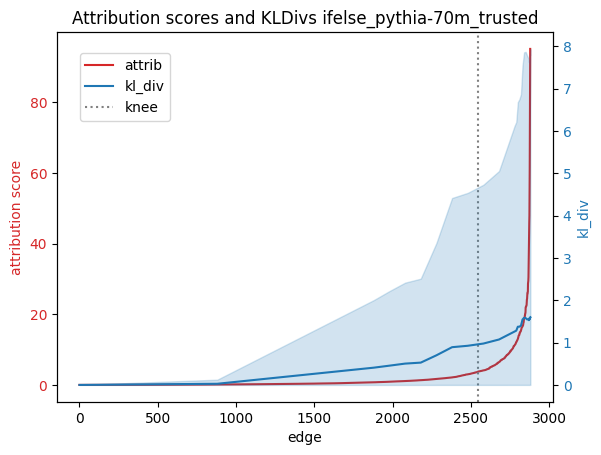

In [43]:
plot_attribution_and_kl_div(attribution_scores_sorted, kl_divs, kneedle.knee, f"{task_name}_{model_name}_trusted", plot_interval=True)

In [44]:
# compute on anomalous data
anomalous_testloader = make_prompt_data_loader(task.test_data.anomalous_data, effect_tokens, task.model, batch_size)

In [45]:
# circuit_outs_anom_path = out_dir / "circuit_outs_anom.pt"
# if circuit_outs_anom_path.exists():
#     circuit_outs_anom = torch.load(circuit_outs_anom_path)
# else:
circuit_outs_anom: CircuitOutputs = run_circuits(
    model=model,
    dataloader=anomalous_testloader,
    test_edge_counts=
    #[0, model.n_edges - kneedle.knee, model.n_edges],
    edge_counts_util(
        edges=model.edges, 
        prune_scores=attribution_scores,
        test_counts=EdgeCounts.LOGARITHMIC
    ),
    prune_scores=attribution_scores,
    patch_type=PatchType.TREE_PATCH,
    ablation_type=AblationType.ZERO,
)
# torch.save(circuit_outs_anom, circuit_outs_anom_path)

kl_divs_anom = measure_kl_div(model, anomalous_testloader, circuit_outs_anom, over_vals=True)

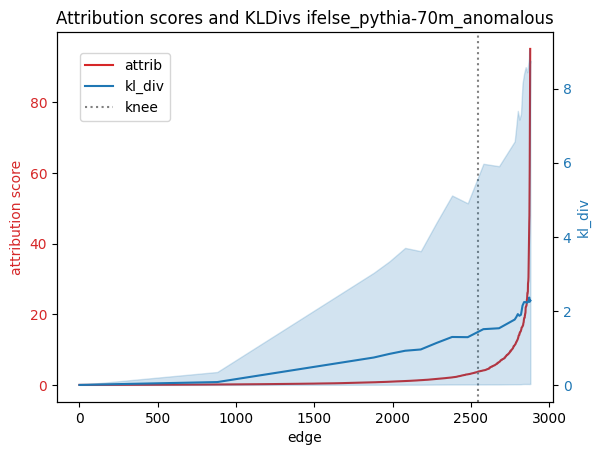

In [46]:
plot_attribution_and_kl_div(attribution_scores_sorted, kl_divs_anom, kneedle.knee, f"{task_name}_{model_name}_anomalous", plot_interval=True)

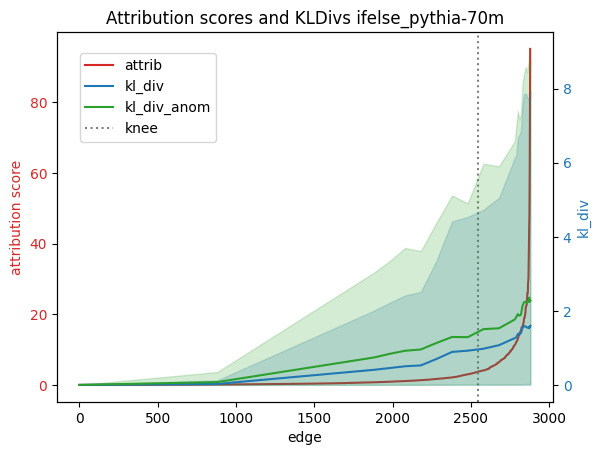

In [47]:
plot_attribution_and_kl_div(attribution_scores_sorted, kl_divs, kneedle.knee, f"{task_name}_{model_name}", kl_divs_anom=kl_divs_anom, plot_interval=True)

ok, so I want to 
- [X] add error bars for indidivudal kl divs
- compute instance circuits using knee point, compute average sparsity and kl 
- reproduce these graphs on "standard" cirucit benchmarks, not plotting anomalous
- repoduce these graphs on other MAD tasks
- repoduce these graphs using edge pruning
